In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import pdfplumber

# Creating Labels

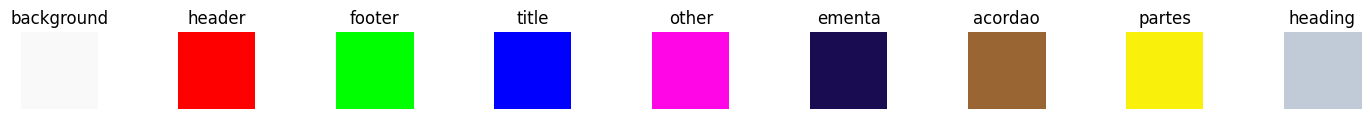

[0 1 2 3 4 5 6 7 8]
{'background': 0, 'header': 1, 'footer': 2, 'title': 3, 'other': 4, 'ementa': 5, 'acordao': 6, 'partes': 7, 'heading': 8}


In [6]:
#Colors:
WITHE = (249,249,249)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
PURPLE = (25,12,80)
PINK = (255,6,231)
BROWN = (153,102,51)
YELLOW = (249,241,12)
GREY = (193,203,216)
#labels
BACKGROUND = 'background'
HEADER = 'header'
FOOTER = 'footer'
TITLE = "title"
OTHER = "other"
EMENTA = "ementa"
ACORDAO = "acordao"
PARTES = "partes"
HEADING = "heading"
labels_color = [WITHE,RED,GREEN,BLUE,PINK,PURPLE,BROWN,YELLOW,GREY]
labels_str = [BACKGROUND,HEADER,FOOTER,TITLE,OTHER,EMENTA,ACORDAO,PARTES,HEADING]
n_labels = len(labels_str)
fig = plt.figure( figsize=(n_labels*2,1))
c = 1;
for lc,l in zip(labels_color,labels_str):
  plt.subplot(1, n_labels, c)
  plt.axis('off')
  label = np.zeros((50,50,3), np.uint8)
  label[:,0:] = lc
  plt.title( l )
  plt.imshow(label)
  c=c+1
plt.show()

labels = np.arange(len(labels_color))
print(labels)
color_label_dic = {}
for l,c in enumerate(labels_str):
  color_label_dic[labels_str[l]]= l
print(color_label_dic)

# Loading dataset

In [7]:
df = pd.read_csv('image_pre_cv.csv')
print(f'Tamanho dataset: {len(df.values)}')

Tamanho dataset: 994


In [197]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 9
NUM_TRAIN_IMAGES = 800
NUM_EVAL_IMAGES = 94
NUM_EVAL_IMAGES += NUM_TRAIN_IMAGES

In [198]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [199]:
imgs,masks = df['img_path'].values,df['mask_path'].values
train_images, train_masks, val_images, val_masks,test_images, test_masks = imgs[:NUM_TRAIN_IMAGES],masks[:NUM_TRAIN_IMAGES],imgs[NUM_TRAIN_IMAGES:NUM_EVAL_IMAGES],masks[NUM_TRAIN_IMAGES:NUM_EVAL_IMAGES],imgs[NUM_EVAL_IMAGES:],masks[NUM_EVAL_IMAGES:]
print('train_images',len(train_images),'val_images',len(val_images),'test_images',len(test_images))
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images,test_masks)
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

train_images 800 val_images 94 test_images 100
Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


# Defining model

Reference: https://keras.io/examples/vision/deeplabv3_plus/ 

    Author: Soumik Rakshit
  
    Last Accessed: 2023/02/03


In [160]:
import keras
from keras import layers

In [220]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
    # * Modification of author code: adding other convolution layer and more dilation 
    out_32 = convolution_block(dspp_input, kernel_size=3, dilation_rate=32)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18,out_32])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [214]:
keras.backend.clear_session()

In [221]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [222]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

In [223]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/5
200/200 [==============================] - 24s 106ms/step - loss: 0.1216 - accuracy: 0.9588 - val_loss: 0.0609 - val_accuracy: 0.9759
Epoch 2/5
200/200 [==============================] - 21s 104ms/step - loss: 0.0480 - accuracy: 0.9790 - val_loss: 0.0427 - val_accuracy: 0.9812
Epoch 3/5
200/200 [==============================] - 21s 104ms/step - loss: 0.0298 - accuracy: 0.9829 - val_loss: 0.0410 - val_accuracy: 0.9816
Epoch 4/5
200/200 [==============================] - 21s 104ms/step - loss: 0.0282 - accuracy: 0.9827 - val_loss: 0.0387 - val_accuracy: 0.9818
Epoch 5/5
200/200 [==============================] - 21s 104ms/step - loss: 0.0298 - accuracy: 0.9819 - val_loss: 0.0383 - val_accuracy: 0.9829


# Plotting training result

In [225]:
def plot_graphs_model(history, model_name):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle(model_name)
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel('accuracy')
  ax1.legend(['accuracy', 'val_accuracy'])
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel('loss')
  ax2.legend(['loss', 'val_loss'])
  plt.show()

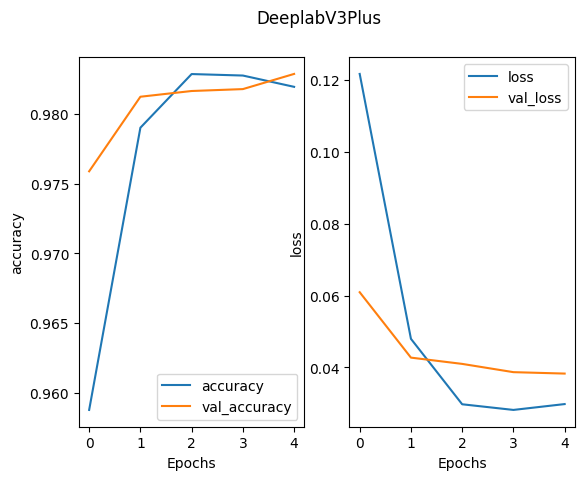

In [226]:
plot_graphs_model(history, 'DeeplabV3Plus')

# Checking some predicted masks

In [118]:
colormap = [WITHE,RED,GREEN,BLUE,PINK,PURPLE,BROWN,YELLOW,GREY]

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

def decode_segmentation_masks(mask, colormap):
  mask_img = np.zeros((IMAGE_SIZE,IMAGE_SIZE,3),np.uint8)
  for x in range(IMAGE_SIZE):
    for y in range(IMAGE_SIZE):
      value = mask[x,y]
      mask_img[x,y] = colormap[value]
  return mask_img

def get_overlay(image, colored_mask):
  image = tf.keras.preprocessing.image.array_to_img(image)
  image = np.array(image).astype(np.uint8)
  overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
  return overlay

def plot_samples_matplotlib(display_list, figsize=(5, 3)):
  _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
  for i in range(len(display_list)):
      if display_list[i].shape[-1] == 3:
          axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
      else:
          axes[i].imshow(display_list[i])
  plt.show()

def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

1/1 [==============================] - 1s 633ms/step


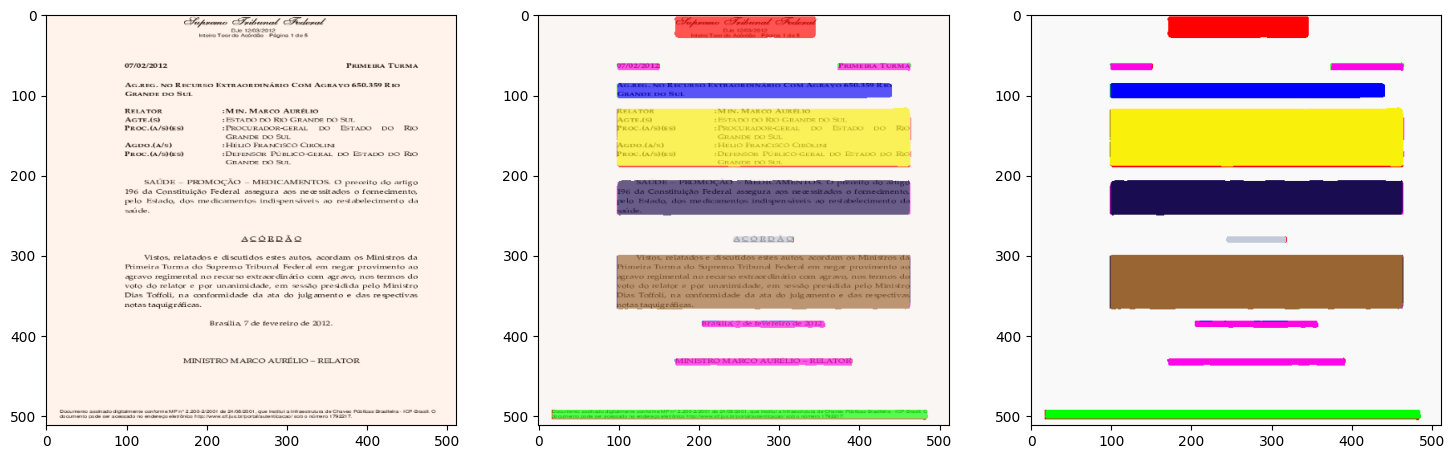

1/1 [==============================] - 0s 15ms/step


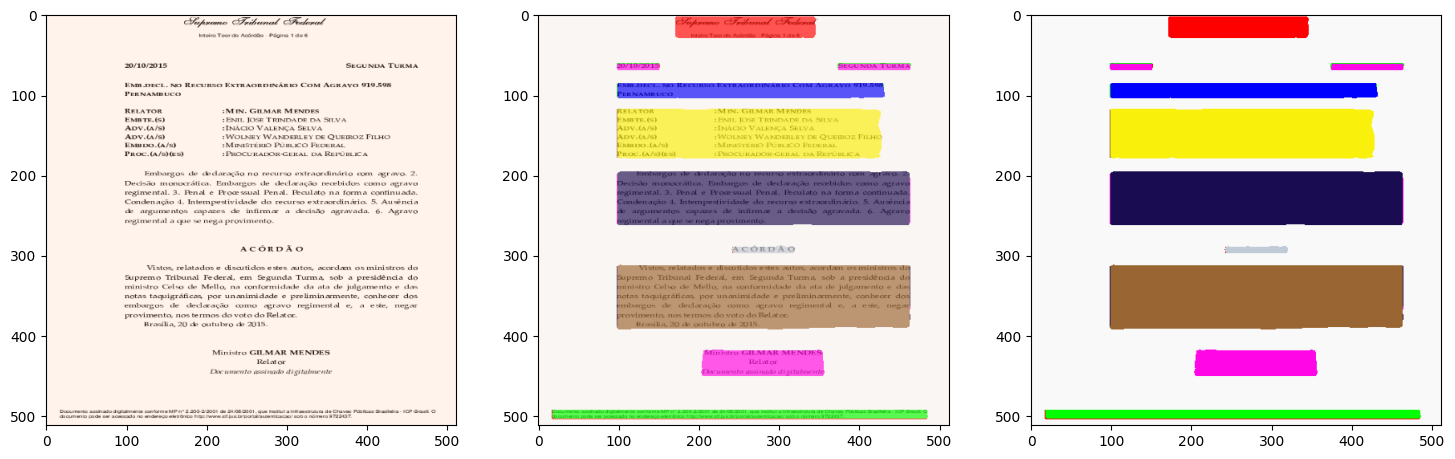

1/1 [==============================] - 0s 17ms/step


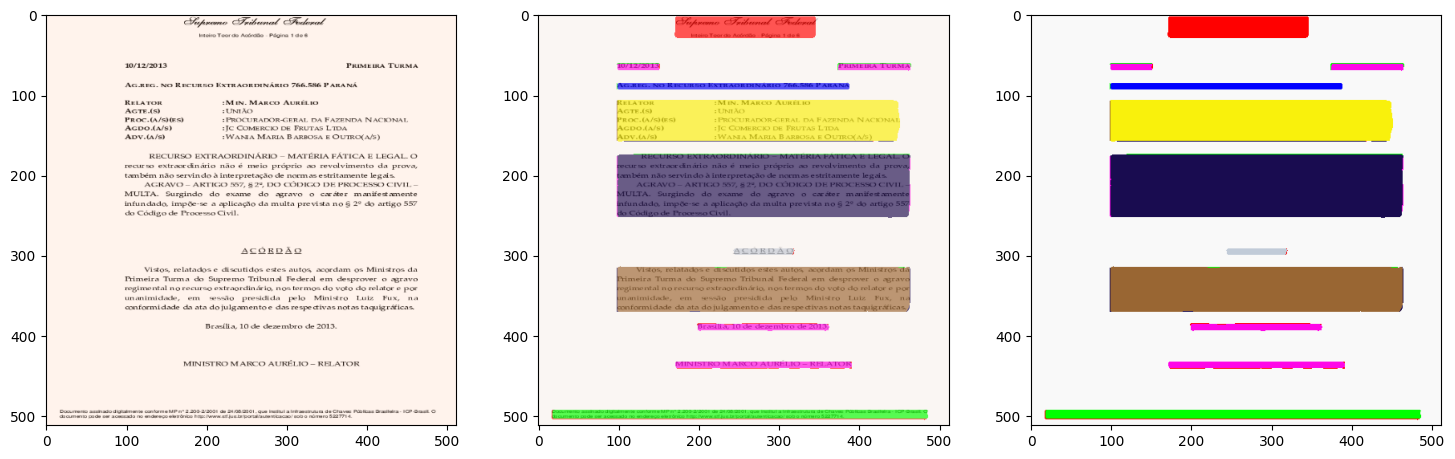

1/1 [==============================] - 0s 14ms/step


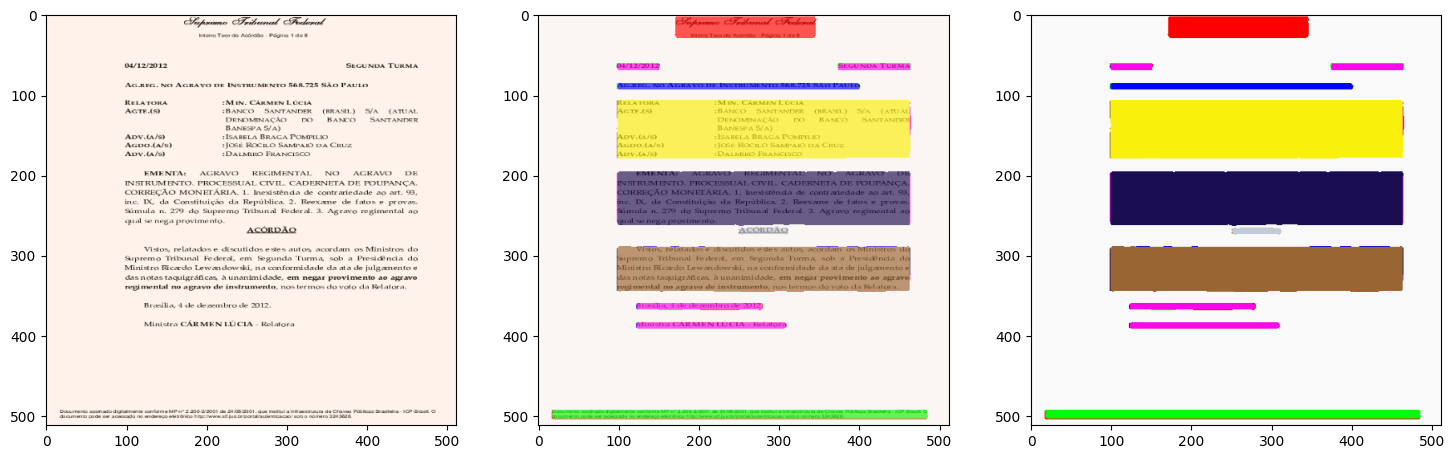

In [224]:
plot_predictions(test_images[:4], colormap, model=model)

# Defining text retrieval and evaluation

In [255]:
def get_bbox(mask,label,img_size=(595,842)):
    mask = mask == label
    mask = mask.astype(np.uint8)
    mask = cv2.resize(mask, img_size, interpolation = cv2.INTER_LINEAR)
    contours,_ = cv2.findContours(mask,cv2.RETR_EXTERNAL  ,cv2.CHAIN_APPROX_NONE)
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    cnt=contours[max_index]
    x,y,w,h = cv2.boundingRect(cnt)
    bbox = [x ,y,x+w,y+h]
    return bbox

In [240]:
def obj_in_bbox(obj,_bbox):
            v_mid = (obj["top"] + obj["bottom"]) / 2
            h_mid = (obj["x0"] + obj["x1"]) / 2
            x0, top, x1, bottom = _bbox
            return (h_mid >= x0) and (h_mid < x1) and (v_mid >= top) and (v_mid < bottom)

In [257]:
def get_bbox_text(image_path,bbox):
    image_path = image_path.split("/")[-1]
    id = image_path.replace('.png','')
    pdf_idtm_path = f'./ITD_MINI/{id}/{id}.pdf'
    with pdfplumber.open(pdf_idtm_path) as pdf:
        words = pdf.pages[0].extract_words()
        return " ".join([w['text'] for w in words if obj_in_bbox(w,bbox)])

In [262]:
# Test pred mask and get text
test_img,test_mask = test_images[0],test_masks[0] 
test_mask = cv2.imread(test_mask)
test_mask = cv2.cvtColor(test_mask, cv2.COLOR_BGR2GRAY)
label = color_label_dic['ementa']
bbox = get_bbox(test_mask,label)
true_text = get_bbox_text(test_img,bbox)
print(f'True : {true_text}')
image_tensor = read_image(test_img)
prediction_mask = infer(image_tensor=image_tensor, model=model)
label = color_label_dic['ementa']
bbox = get_bbox(prediction_mask,label)
pred_text = get_bbox_text(test_img,bbox)
print(f'Pred : {true_text}')

True : SAÚDE – PROMOÇÃO – MEDICAMENTOS. O preceito do artigo 196 da Constituição Federal assegura aos necessitados o fornecimento, pelo Estado, dos medicamentos indispensáveis ao restabelecimento da saúde.
1/1 [==============================] - 0s 16ms/step
Pred : SAÚDE – PROMOÇÃO – MEDICAMENTOS. O preceito do artigo 196 da Constituição Federal assegura aos necessitados o fornecimento, pelo Estado, dos medicamentos indispensáveis ao restabelecimento da saúde.


In [268]:
from Levenshtein import distance,ratio
#Test Levenshtein dist/ratio
original_text = 'SAÚDE – PROMOÇÃO – MEDICAMENTOS. O preceito do artigo 196 da Constituição Federal assegura aos necessitados o fornecimento, pelo Estado, dos medicamentos indispensáveis ao restabelecimento da saúde.'
original_copy = 'SAÚDE – PROMOÇÃO – MEDICAMENTOS. O preceito do artigo 196 da Constituição Federal assegura aos necessitados o fornecimento, pelo Estado, dos medicamentos indispensáveis ao restabelecimento da saúde.'
original_3_modified  = 'SÚDE – PWOMOÇÃ – MEDICAMENTOS. O preceito do artigo 196 da Constituição Federal assegura aos necessitados o fornecimento, pelo Estado, dos medicamentos indispensáveis ao restabelecimento da saúde.'
print(f'Original vs Copy, distance: {distance(original_text,original_copy)},  ratio: {ratio(original_text,original_copy)}')
print(f'Original vs Modified, distance: {distance(original_text,original_3_modified)},  ratio: {ratio(original_text,original_3_modified)}')

Original vs Copy, distance: 0,  ratio: 1.0
Original vs Modified, distance: 3,  ratio: 0.9898477157360406


# Performance evaluation on all test

In [250]:


rows = []
i = 0
for test_img,test_mask in zip(test_images,test_masks):
    test_mask = cv2.imread(test_mask)
    test_mask = cv2.cvtColor(test_mask, cv2.COLOR_BGR2GRAY)
    label = color_label_dic['ementa']
    bbox = get_bbox(test_mask,label)
    true_text = get_bbox_text(test_img,bbox)
    image_tensor = read_image(test_img)
    prediction_mask = infer(image_tensor=image_tensor, model=model)
    label = color_label_dic['ementa']
    bbox = get_bbox(prediction_mask,label)
    pred_text = get_bbox_text(test_img,bbox)
    dist = distance(true_text, pred_text)
    rto = ratio(true_text, pred_text)
    rows.append([i,dist,rto])
    #print(true_text, pred_text)
    i+=1
cols = ['test_example','dist_true_pred','ratio_true_pred']
dft = pd.DataFrame(columns=cols,data=rows)
dft.head(14)

1/1 [==============================] - 0s 15ms/step


,test_example,dist_true_pred,ratio_true_pred
0,0,0,1.0
1,1,0,1.0
2,2,0,1.0
3,3,0,1.0
4,4,0,1.0
5,5,0,1.0
6,6,0,1.0
7,7,0,1.0
8,8,0,1.0
9,9,0,1.0


In [251]:
dft['dist_true_pred'].value_counts()

0    100
Name: dist_true_pred, dtype: int64

100% text test retrieved successfully through predicted masks